# Photometric Stereo Exercise

Note: Please make sure to run the script ```get_data.sh``` in the folder data first, to download the necessary dataset for this exercise! Otherwise it will not work.

## Preliminaries
In this exercise, you will perform photometic stereo reconstruction. You are given a number of images that have been taken from an identical camera position, but with a different light position for each image.
Using the methods you have learned in the lecture you will recover the normal and albedo information. 

But first, the necessary imports:

In [46]:
from pathlib import Path
import inspect
import os

from PIL import Image
import numpy as np

from matplotlib import pyplot as plt

# find the data directory by looking at this files position on your system
DATA_DIR = Path(os.getcwd()).joinpath("data","psmImages_png", "psmImages")

assert (
    DATA_DIR.exists()
), "input data does not exist - please mak e sure to run ./get_data.sh in data folder"


First of all, we need a function to load the images, masks and light directions. 
Normally, the surface light positions would need to be recovered from the images in the chrome folder, where a chrome ball has been photographed for the different light positions. This would enable you to recover the specular highlights using thresholding and to recover the light positions from that.
To keep this exercise short and to focus on the actual photometric stereo reconstruction, we provide the light directions directly:

In [47]:
def load_imgs_masks_light_dirs(object_name="cat"):
    """
    returns:
    imgs np.array [k,h,w] np.float32 [0.0, 1.0]
    mask np.array [h,w] np.bool
    light_positions np.array [k,3] np.float32
    k: number of images
    h: image height (num rows)
    w: image width (num cols)
    """
    available_objs = [
        x.stem for x in DATA_DIR.iterdir() if x.is_dir() and "chrome" not in str(x)
    ]

    assert (
        object_name in available_objs
    ), "unknown obj {0} - please select one of {1}".format(object_name, available_objs)

    obj_dir = DATA_DIR.joinpath(object_name)

    mask = (
        np.array(
            Image.open(
                obj_dir.joinpath("{}.{}.png".format(object_name, "mask"))
            ).convert("L")
        )
        > 0
    )

    imgs = []
    for im_path in sorted(list(obj_dir.glob("*.png"))):
        if "mask" in str(im_path):
            # we already got that one
            continue
        else:
            img = Image.open(im_path).convert("L")
            imgs.append(np.array(img))

    imgs = np.stack(imgs, axis=0).astype(np.float64) / 256.0

    # normally these would have to be recovered from the chrome ball
    # we hard-code them here to save time
    light_dirs = np.array(
        [
            [0.49816584, 0.46601385, 0.73120577],
            [0.24236702, 0.13237001, 0.96111207],
            [-0.03814999, 0.17201198, 0.98435586],
            [-0.09196399, 0.44121093, 0.89267886],
            [-0.31899811, 0.50078717, 0.80464428],
            [-0.10791803, 0.55920516, 0.82197524],
            [0.27970709, 0.42031713, 0.86319028],
            [0.09845196, 0.42847982, 0.89817162],
            [0.20550002, 0.33250804, 0.9204391],
            [0.08520805, 0.33078218, 0.93985251],
            [0.12815201, 0.043478, 0.99080105],
            [-0.13871804, 0.35998611, 0.92258729],
        ]
    )

    return imgs, mask, light_dirs
    

Now we can have a look at one of the images and the mask:

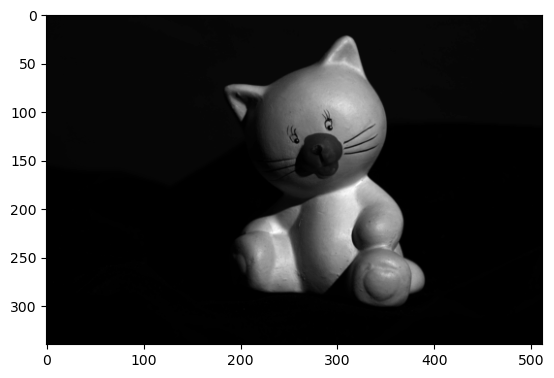

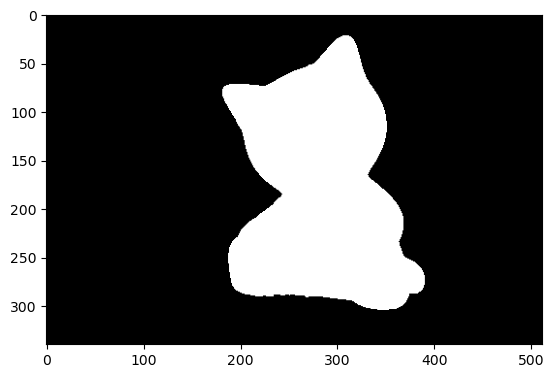

In [68]:
imgs, mask, light_positions = load_imgs_masks_light_dirs("cat")
plt.figure()
plt.imshow(imgs[0], cmap=plt.cm.gray)
plt.show()

plt.figure()
plt.imshow(mask, cmap=plt.cm.gray)
plt.show()

In the lecture, you have learned how to perform photometric stereo reconstruction.
Now, fill in the gaps of the ```compute_normals_albedo``` function! 

In [69]:
def compute_normals_albedo_map(imgs, mask, light_positions):
    """
    imgs np.array [k,h,w] np.float32 [0.0, 1.0]
    mask np.array [h,w] np.bool
    light_positions np.array [k,3] np.float32
    ---
    dims:
    k: number of images
    h: image height (num rows)
    w: image width (num cols)
    """
    # BEGIN REGION SOLUTION
    normals = np.linalg.pinv(light_positions) @ imgs.reshape(imgs.shape[0], -1)
    rho = np.linalg.norm(normals, ord=2, axis=0)
    rho = rho + np.finfo(np.float32).eps
    normals_unit = normals / rho
    rho = rho.reshape(imgs.shape[1], imgs.shape[2])
    normals_unit = normals_unit.T.reshape(imgs.shape[1], imgs.shape[2], 3)
    print(normals_unit.shape)
    print(mask.shape)
    musk = np.tile(mask,(1,1,1)).reshape(imgs.shape[1], imgs.shape[2], 1)
    print(musk.shape)
    normals_unit = normals_unit * musk
    # END REGION SOLUTION

    assert normals_unit.shape == (imgs.shape[1], imgs.shape[2], 3)
    assert rho.shape == (imgs.shape[1], imgs.shape[2])

    rho = np.clip(rho,0.0,1.0)
    normals_unit = np.clip(normals_unit, 0.0, 1.0)

    return normals_unit, rho, mask

Good, now let's have a look at the result!

(340, 512, 3)
(340, 512)
(340, 512, 1)


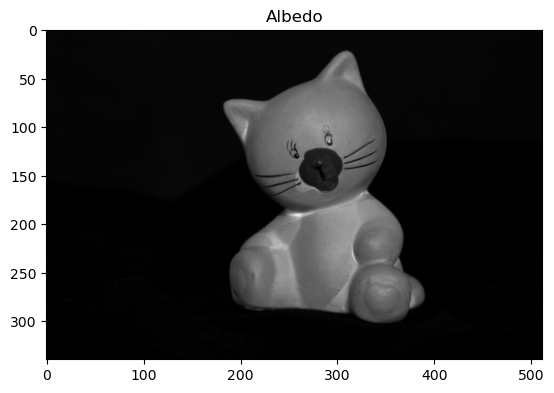

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


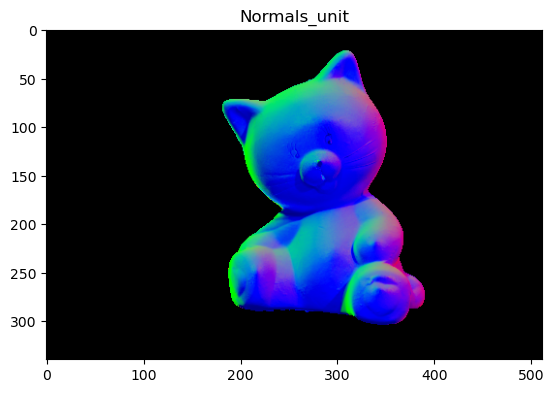

In [70]:
normals_unit, rho, mask = compute_normals_albedo_map(imgs, mask, light_positions)

plt.figure()
plt.imshow(rho, cmap=plt.cm.gray)
plt.title("Albedo")
plt.show()

plt.figure()
plt.imshow(normals_unit)
print(normals_unit)
plt.title("Normals_unit")
plt.show()


We now know the pixel-wise normal and albedo for the whole image! This enables us to relight the scene (i.e. to artificially change the light position) and observe the result.
Please fill in the missing pieces in ```relight_scene```
```albedo``` could be a grid of albedos for each pixel in the scene, or a single albedo for the whole image.

In [73]:
def relight_scene(light_pos, normals_unit, albedo, mask):
    """
    light_pos np.array [k,3] np.float32
    mask np.array [h,w] np.bool
    ----
    dims:
    h: image height (num rows)
    w: image width (num cols)
    ----
    returns:
        imgs np.array [h,w] np.float32 [0.0, 1.0]
    """
    assert light_pos.shape == (3,)
    assert np.allclose(1.0, np.linalg.norm(light_pos))
    assert normals_unit.shape[-1] == 3
    assert len(normals_unit.shape) == 3

    # BEGIN REGION SOLUTION
    img_norm = albedo * np.sum(normals_unit * light_pos, axis=-1)
    img_norm = (img_norm - img_norm.min()) / (img_norm.max() - img_norm.min())
    img_norm = img_norm * mask

    # END REGION SOLUTION
    assert np.all(
        np.logical_and(0.0 <= img_norm, img_norm <= 1.0)
    ), "please normalize your image to interval [0.0,1.0]"
    return img_norm


Now, let's change the light position a bit! You can also play with the albedo:
Here we move the light along the x Axis a bit.


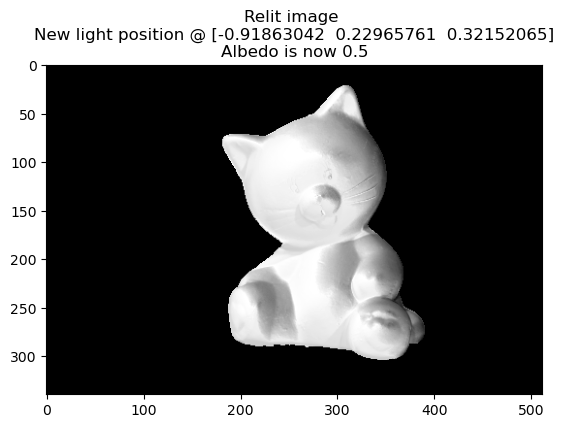

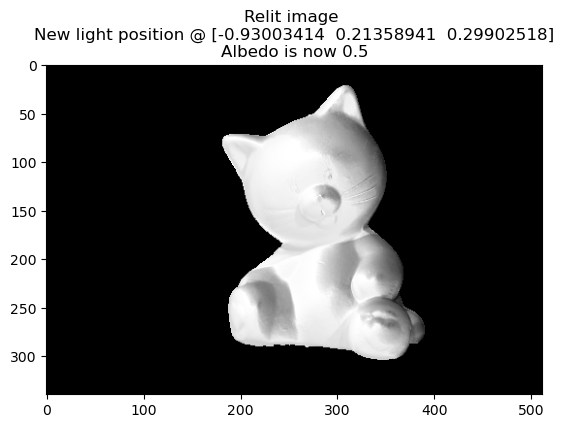

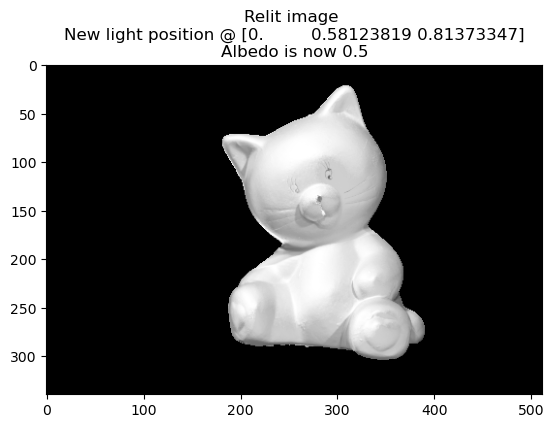

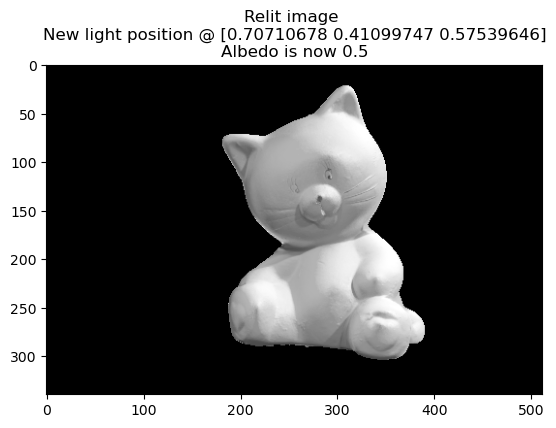

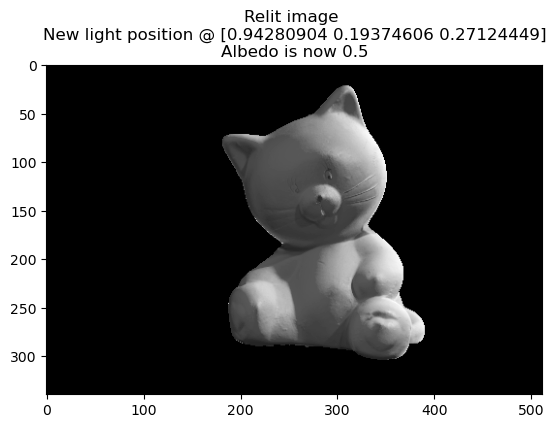

In [74]:
light_pos = np.array([0.5, 0.5, 0.7])
new_albedo = 0.5
for x in np.linspace(-2, 2, 5):
    light_pos[0] = x
    light_pos = np.array(light_pos / np.linalg.norm(light_pos))

    new_img = relight_scene(light_pos, normals_unit, new_albedo, mask)

    plt.figure()
    plt.imshow(new_img, cmap=plt.cm.gray)
    plt.title(
        "Relit image \nNew light position @ {0}\nAlbedo is now {1}".format(light_pos, new_albedo)
        )
    plt.show()

Congratulations, you have successfully completed the photometric stereo exercise. Maybe you want to play around and try implementing a function that can produce RGB images using a per-color-channel albedo map? :)